In [1]:
from collections import defaultdict
import json
from glob import glob
from typing import Tuple

from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy import exp
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns

from statistics import kolmogorov_smirnov
from utils import load_samples_as_data_frame
from views import plot_distribution_comparison

mpl.rcParams['lines.linewidth'] = 2.5

# Base line variant distribution

In [2]:
normals, variants = load_samples_as_data_frame(glob('output/tumor_derived/*.json'))

In [6]:
def plot_distribution_with_peaks(seq, label=None):
    n = 5
    peak_constaints = {"width": 15, "distance": 50, "rel_height": 0.85}
    seq /= sum(seq)
    peaks, properties = find_peaks(seq.rolling(n).mean(), **peak_constaints)

    fragment_window = [50, 500]
    seq.plot(label=label, zorder=0)
    plt.plot(peaks, seq[peaks], "o", zorder=1)
    plt.hlines(
        y=properties["width_heights"],
        xmin=properties["left_ips"],
        xmax=properties["right_ips"],
        color="C1",
        zorder=2,
    )
    plt.xlim(fragment_window)

# Everything together


In [14]:
normals_pooled = normals.groupby("length (bp)").sum().sum(axis=1).astype(int)
variants_pooled = variants.groupby("length (bp)").sum().sum(axis=1).astype(int)

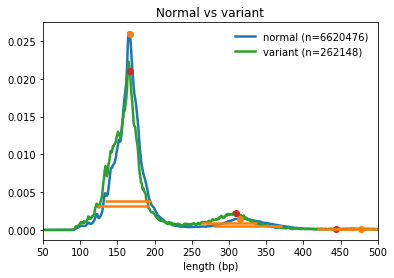

In [15]:
plt.title('Normal vs variant')
plot_distribution_with_peaks(normals_pooled, label=f'normal (n={normals_pooled.sum()})')
plot_distribution_with_peaks(variants_pooled, label=f'variant (n={int(variants_pooled.sum())})')
plt.legend(frameon=False)
plt.savefig('figs/normal_variant.png')

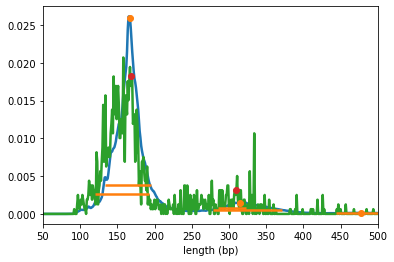

In [17]:
plot_distribution_with_peaks(normals_pooled, label='normal')
plot_distribution_with_peaks(variants.groupby('length (bp)').sum()['ROS1'])

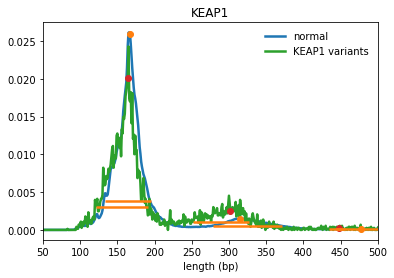

In [18]:
plt.title('KEAP1')
plot_distribution_with_peaks(normals_pooled, label='normal')
plot_distribution_with_peaks(variants.groupby('length (bp)').sum()['KEAP1'], label='KEAP1 variants')
plt.legend(frameon=False)
plt.savefig('figs/keap1.png')

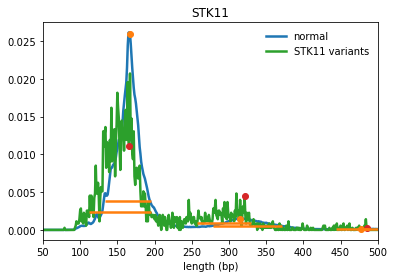

In [19]:
plt.title('STK11')
plot_distribution_with_peaks(normals_pooled, label='normal')
plot_distribution_with_peaks(variants.groupby('length (bp)').sum()['STK11'], label='STK11 variants')
plt.legend(frameon=False)
plt.savefig('figs/stk11.png')

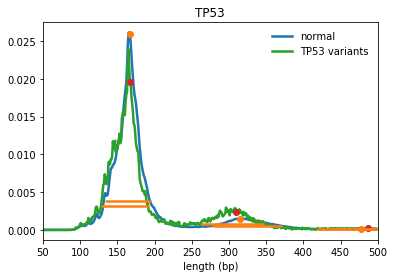

In [20]:
plt.title('TP53')
plot_distribution_with_peaks(normals_pooled, label='normal')
plot_distribution_with_peaks(variants.groupby('length (bp)').sum()['TP53'], label='TP53 variants')
plt.legend(frameon=False)
plt.savefig('figs/tp53.png')

In [ ]:
def compare_peak_shifts(variant_distribution, reference_distribution):
    """
    Calculate the peak position and width for each gene distribution, and compare to reference distributions.
    
    Focus on distributions that are statistically significant.
    """
    n = 5  # Number of base pair smoothing.
    peak_constaints = {'width': 15, 'distance': 80, 'rel_height': 0.85}
    ref_peaks, ref_properties = find_peaks(reference_distribution.rolling(n).mean(), **peak_constaints)
    
    def peak_shift(sequence, num_peaks=2):
        """ Calculate shift and broadening for given sequence. """
        peaks, props = find_peaks(sequence.rolling(n).mean(), **peak_constaints)
        max_peaks = min(num_peaks, len(peaks), len(ref_peaks))
       
        s1 = pd.Series({
            f'{peak_number+1}_shift': peaks[peak_number] - ref_peaks[peak_number]
            for peak_number in range(max_peaks)
        })
        print(s1.index)
        s2 = pd.Series({
            f'{peak_number+1}_broadening': props['widths'][peak_number] - ref_properties['widths'][peak_number]
            for peak_number in range(max_peaks)
        })
        return pd.concat([s1,s2])

    # Filter columns on statistical significance.
    significant_columns = tuple(
        c 
        for c in variant_distribution.columns 
        if kolmogorov_smirnov(reference_distribution, variant_distribution[c]) < 0.05
    )
    # Calculate shift for each gene.
    data_frame = pd.DataFrame(columns=significant_columns)
    for c in significant_columns:
        print(c)
        data_frame[c] = peak_shift(variant_distribution[c])
    return data_frame


In [ ]:
df = compare_peak_shifts(variants, normals.sum(axis=1)).T

In [ ]:
def plot_peak(df, peak_number: int):
#     plt.figure(figsize=(4,3))
    plt.title(f'Peak {peak_number}')
    x_column = f'{peak_number}_shift'
    y_column = f'{peak_number}_broadening'
    xlim = (min(df[x_column])-2, max(df[x_column])+2)
    ylim = (min(df[y_column])-2, max(df[y_column])+2)
    plt.plot([0, 0], ylim, '-k', zorder=1, alpha=0.5)
    plt.plot(xlim, [0, 0], '-k', zorder=1, alpha=0.5)

    plt.xlim(xlim)
    plt.ylim(ylim)
    sns.scatterplot(
        x=x_column, 
        y=y_column, 
        hue=df.index,
        data=df,
        zorder=2,
    )
    plt.ylabel('Broadening (bp)')
    plt.xlabel('Shift (bp)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

In [ ]:
plot_peak(df, peak_number=1)
plt.savefig('figs/peak1.png', bbox_inches='tight')

In [ ]:
plot_peak(df, peak_number=2)
plt.savefig('figs/peak2.png', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(3, 3))
from scipy.signal import find_peaks

seq = variants.sum(axis=1)
n = 5
peaks, properties = find_peaks(seq.rolling(n).mean(), width=15, distance=100)
print(peaks)
print(properties['widths'])
seq.plot()
seq.plot()
fragment_window = [50, 500]
plt.xlim(fragment_window)
plt.plot(peaks, seq[peaks], 'o')
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")

In [ ]:
plot_distribution_comparison(normals.sum(axis=1), variants.sum(axis=1), filename_suffix='all')

In [ ]:
# for gene in normals.columns:
#     f = plt.figure(figsize=(8,3))
#     plt.title(gene)
#     plot_distribution_comparison(normals[gene], variants[gene])

In [ ]:
plot_distribution_comparison(normals.sum(axis=1), variants['ABL1'], filename_suffix='EGFR')

In [ ]:
plot_distribution_comparison(normals.sum(axis=1), normals['EGFR'], filename_suffix='EGFR')

In [ ]:
# Check that all normal genes are not significantly different.
significant_columns = tuple(
    c 
    for c in normals.columns 
    if kolmogorov_smirnov(normals.sum(axis=1), normals[c]) < 0.05/len(normals.columns)
)
significant_columns

In [ ]:
plot_distribution_comparison(normals.sum(axis=1), normals['ROS1'])